In [1]:

import numpy as np
import pandas as pd
from pathlib import Path
import gc
import matplotlib.pyplot as plt

# xsuite
import xtrack as xt
import xmask as xm
import xfields as xf
import xpart as xp


import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as tune
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Base as phys
import BBStudies.Physics.Constants as cst

from IPython.display import clear_output




# Importing Collider and Twiss
#-------------------------------------
collider = xt.Multiline.from_json('colliders/collider_NO_OCTU.json')
twiss = {}
twiss['lhcb1'] = collider['lhcb1'].twiss().to_pandas()
twiss['lhcb2'] = collider['lhcb2'].twiss().reverse().to_pandas()
#-------------------------------------


# Filtering twiss to get rid of slices, entries and exits
#-------------------------------------
light_twiss = {}
for sequence in ['lhcb1','lhcb2']:
    light_twiss[sequence] = xPlus.filter_twiss(twiss[sequence].set_index('name'),entries=['drift','..','_entry','_exit']).reset_index()
#-------------------------------------

clear_output()

---
# Generating particles
---

In [24]:

nemitt_x    = 1.8e-6
nemitt_y    = 1.8e-6
sigma_z     = 0.09
line        = collider['lhcb1']
at_element  = 'tcp.c6l7.b1'





generator = phys.polar_grid(r_sig     = [0] + list(np.linspace(0.1,6.5,15)),
                            theta_sig = np.linspace(0,2*np.pi,100))
generator = generator.rename(columns={'y_sig':'px_sig'})[['x_sig','px_sig']]
n_part = len(generator)


# Longitudinal plane: generate gaussian distribution matched to bucket 
# zeta, delta, matcher = xp.generate_longitudinal_coordinates(num_particles=n_part, distribution='gaussian',sigma_z=sigma_z, line=line,return_matcher=True)
# nemitt_zeta = matcher._compute_emittance(matcher.rfbucket,matcher.psi)

if line is not None:
    particles = xp.build_particles( line    = line,
                                    x_norm  = generator.x_sig.values,
                                    px_norm = generator.px_sig.values,
                                    y_norm  = None,
                                    py_norm = None,
                                    zeta    = None,
                                    delta   = None,
                                    nemitt_x   = nemitt_x, nemitt_y=nemitt_y,
                                    at_element = at_element)
else:
    particles = None


df    = particles.to_pandas()
df.insert(list(df.columns).index('zeta'),'pzeta',df['ptau']/df['beta0'])

line = collider['lhcb1']
pco  = line.twiss().particle_on_co
line.track(pco,ele_stop=at_element)
coord = xPlus.coordinate_table(df[['particle_id','x','px','y','py','zeta','pzeta']],W_matrix=line.twiss().to_pandas().set_index('name').loc[at_element].W_matrix,particle_on_co=pco,nemit_x=nemitt_x ,nemit_y=nemitt_y ,nemit_zeta=0)
# coord = xPlus.coordinate_table(df[['particle_id','x','px','y','py','zeta','pzeta']],W_matrix=line.twiss().to_pandas().set_index('name').loc[at_element].W_matrix,particle_on_co=line.twiss().particle_on_co,nemit_x=nemitt_x ,nemit_y=nemitt_y ,nemit_zeta=0)
# coord = xPlus.coordinate_table(df[['particle_id','x','px','y','py','zeta','pzeta']],W_matrix=twiss['lhcb1'].W_matrix[0],particle_on_co=collider['lhcb1'].twiss().particle_on_co,nemit_x=nemitt_x ,nemit_y=nemitt_y ,nemit_zeta=0)

In [27]:
particles

Particles(_capacity=1600, _num_active_particles=1600, _num_lost_particles=0, start_tracking_at_element=36806, q0=1.0, mass0=938272088.16, _p0c=[6.79999994e+12 6.79999994e+12 6.79999994e+12 ... 6.79999994e+12
 6.79999994e+12 6.79999994e+12], _gamma0=[7247.36468857 7247.36468857 7247.36468857 ... 7247.36468857 7247.36468857
 7247.36468857], _beta0=[0.99999999 0.99999999 0.99999999 ... 0.99999999 0.99999999 0.99999999], s=[13126.4636 13126.4636 13126.4636 ... 13126.4636 13126.4636 13126.4636], zeta=[2.59385039e-06 2.60549476e-06 2.65872616e-06 ... 3.24427154e-06
 3.29750294e-06 3.35073434e-06], _ptau=[1.85287526e-06 1.85287544e-06 1.85287623e-06 ... 1.85288498e-06
 1.85288578e-06 1.85288657e-06], _delta=[1.85287528e-06 1.85287545e-06 1.85287625e-06 ... 1.85288500e-06
 1.85288580e-06 1.85288659e-06], _rpp=[0.99999815 0.99999815 0.99999815 ... 0.99999815 0.99999815 0.99999815], _rvv=[1. 1. 1. ... 1. 1. 1.], chi=[1. 1. 1. ... 1. 1. 1.], charge_ratio=[1. 1. 1. ... 1. 1. 1.], weight=[0. 0. 0. 

In [117]:
pco

Particles(_capacity=1, _num_active_particles=1, _num_lost_particles=0, start_tracking_at_element=-1, q0=1.0, mass0=938272088.16, _p0c=[6.79999994e+12], _gamma0=[7247.36468857], _beta0=[0.99999999], s=[13126.4636], zeta=[2.59385039e-06], _ptau=[1.85287526e-06], _delta=[1.85287528e-06], _rpp=[0.99999815], _rvv=[1.], chi=[1.], charge_ratio=[1.], weight=[1.], particle_id=[0], at_element=[36806], at_turn=[0], state=[1], parent_particle_id=[0], _rng_s1=[0], _rng_s2=[0], _rng_s3=[0], _rng_s4=[0], x=[8.48901048e-07], y=[1.51445466e-07], px=[-1.11698632e-08], py=[9.34161714e-11])

In [83]:
df['pzeta']

0      6.784922e-07
1      1.132558e-04
2      4.406850e-05
3     -4.213284e-05
4      9.857082e-05
           ...     
115    1.493985e-04
116    1.552919e-04
117    9.227052e-05
118    4.540910e-05
119   -5.215613e-05
Name: pzeta, Length: 120, dtype: float64

In [85]:
def compute_pzeta(delta,beta0):
    # beta0 = particle_ref._xobject.beta0[0]
    delta_beta0 = delta * beta0
    ptau_beta0 = (delta_beta0 * delta_beta0
                            + 2. * delta_beta0 * beta0 + 1.)**0.5 - 1.
    pzeta = ptau_beta0 / beta0 / beta0
    return pzeta

(compute_pzeta(df['delta'],df['beta0'])  - df['pzeta'])/df['pzeta']

0      0.000000e+00
1     -1.960559e-12
2      1.537666e-16
3      2.635054e-12
4      2.749805e-16
           ...     
115    1.814279e-16
116    0.000000e+00
117    0.000000e+00
118    0.000000e+00
119   -0.000000e+00
Length: 120, dtype: float64

In [72]:
beta0 = particle_ref._xobject.beta0[0]
        delta_beta0 = delta * beta0
        ptau_beta0 = (delta_beta0 * delta_beta0
                            + 2. * delta_beta0 * beta0 + 1.)**0.5 - 1.
        pzeta = ptau_beta0 / beta0 / beta0

IndentationError: unexpected indent (1321597286.py, line 2)

In [71]:
df.delt

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
115    0.0
116    0.0
117    0.0
118    0.0
119    0.0
Name: delta, Length: 120, dtype: float64

In [52]:
twiss_at_TCP = twiss['lhcb1'].set_index('name').loc[at_element]
print(f'TWISS (x,px): ({twiss_at_TCP.x:.3e},{twiss_at_TCP.px:.3e})')
print(f'COORD (x,px): ({df.x.mean():.3e},{df.px.mean():.3e})')

TWISS (x,px): (8.489e-07,-1.117e-08)
COORD (x,px): (4.364e-04,-2.616e-06)


In [136]:
particle_on_co_1 = collider['lhcb1'].twiss().particle_on_co
line_cycle = collider['lhcb1'].copy()
line_cycle.cycle(name_first_element=at_element, inplace=True)
particle_on_co_2 = line_cycle.twiss().particle_on_co

Compiling ContextCpu kernels...


278d4967997b4160a00424c7c9629e54.c:5035:11: warning: '_GNU_SOURCE' macro redefined [-Wmacro-redefined]
#  define _GNU_SOURCE // enable GNU libc NAN extension if possible
          ^
/Users/pbelanger/ABPLocal/BBStudies/Executables/miniforge3/envs/py-BB/include/python3.11/pyconfig.h:1690:10: note: previous definition is here
# define _GNU_SOURCE 1
         ^
278d4967997b4160a00424c7c9629e54.c:17803:12: warning: variable 'gamma' set but not used [-Wunused-but-set-variable]
    double gamma          = energy / m0;     // [1]
           ^
278d4967997b4160a00424c7c9629e54.c:18069:9: warning: variable 'i' set but not used [-Wunused-but-set-variable]
    int i=0;
        ^
278d4967997b4160a00424c7c9629e54.c:18157:62: warning: variable 'ps_e_prime' set but not used [-Wunused-but-set-variable]
    double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                             ^
278d4967997b41

Done compiling ContextCpu kernels.


In [137]:
particle_on_co_1.to_pandas()[['x','y','px','py']]

,x,y,px,py
0,-4.073466e-07,-9.266435e-08,-2.267390e-08,-2.705063e-09


In [138]:
particle_on_co_2.to_pandas()[['x','y','px','py']]

,x,y,px,py
0,8.489009e-07,1.514454e-07,-1.116986e-08,9.341580e-11


In [134]:
pco.to_pandas()[['x','y','px','py']]

,x,y,px,py
0,8.489010e-07,1.514455e-07,-1.116986e-08,9.341617e-11


In [135]:
pco.to_pandas()[['x','y','px','py']]

,x,y,px,py
0,8.489010e-07,1.514455e-07,-1.116986e-08,9.341617e-11


In [128]:
line.elements[pco.at_element[0]-2:pco.at_element[0]+2]

(Drift(length=0.5950000000011642),
 Marker(_dummy=0),
 Drift(length=0.0),
 Marker(_dummy=0))

In [20]:
import rich
particles.at_element *= 0  
particles.start_tracking_at_element = 0

In [22]:
particles.to_pandas()

,start_tracking_at_element,q0,mass0,s,zeta,chi,charge_ratio,weight,particle_id,at_element,...,y,px,py,delta,ptau,rvv,rpp,p0c,beta0,gamma0
0,0,1.0,9.382721e+08,13126.4636,0.000003,1.0,1.0,0.0,0,0,...,1.514455e-07,-1.116986e-08,9.341617e-11,0.000002,0.000002,1.0,0.999998,6.800000e+12,1.0,7247.364689
1,0,1.0,9.382721e+08,13126.4636,0.000003,1.0,1.0,0.0,1,0,...,1.518919e-07,-2.560931e-07,8.709269e-11,0.000002,0.000002,1.0,0.999998,6.800000e+12,1.0,7247.364689
2,0,1.0,9.382721e+08,13126.4636,0.000003,1.0,1.0,0.0,2,0,...,1.539325e-07,-1.375742e-06,5.818536e-11,0.000002,0.000002,1.0,0.999998,6.800000e+12,1.0,7247.364689
3,0,1.0,9.382721e+08,13126.4636,0.000003,1.0,1.0,0.0,3,0,...,1.559731e-07,-2.495391e-06,2.927803e-11,0.000002,0.000002,1.0,0.999998,6.800000e+12,1.0,7247.364689
4,0,1.0,9.382721e+08,13126.4636,0.000003,1.0,1.0,0.0,4,0,...,1.580137e-07,-3.615041e-06,3.706940e-13,0.000002,0.000002,1.0,0.999998,6.800000e+12,1.0,7247.364689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0,1.0,9.382721e+08,13126.4636,0.000003,1.0,1.0,0.0,1595,0,...,1.722981e-07,-1.145258e-05,-2.019806e-10,0.000002,0.000002,1.0,0.999998,6.800000e+12,1.0,7247.364689
1596,0,1.0,9.382721e+08,13126.4636,0.000003,1.0,1.0,0.0,1596,0,...,1.743387e-07,-1.257223e-05,-2.308880e-10,0.000002,0.000002,1.0,0.999998,6.800000e+12,1.0,7247.364689
1597,0,1.0,9.382721e+08,13126.4636,0.000003,1.0,1.0,0.0,1597,0,...,1.763793e-07,-1.369188e-05,-2.597953e-10,0.000002,0.000002,1.0,0.999998,6.800000e+12,1.0,7247.364689
1598,0,1.0,9.382721e+08,13126.4636,0.000003,1.0,1.0,0.0,1598,0,...,1.784199e-07,-1.481153e-05,-2.887026e-10,0.000002,0.000002,1.0,0.999998,6.800000e+12,1.0,7247.364689


In [20]:
sum(np.abs(coord.df_sig.x_sig) <1e-10)

5

In [21]:
coord.df.x.loc[np.abs(coord.df_sig.x_sig) <1e-10]

0    -0.000030
24    0.000011
48   -0.000011
72   -0.000072
96    0.000011
Name: x, dtype: float64

In [31]:
twiss['lhcb1'].set_index('name').loc[at_element].px

-1.1169863220321754e-08

In [8]:
%matplotlib widget

(-7.146563901765239, 7.149836376274536, -7.149100012868207, 7.149100012868207)

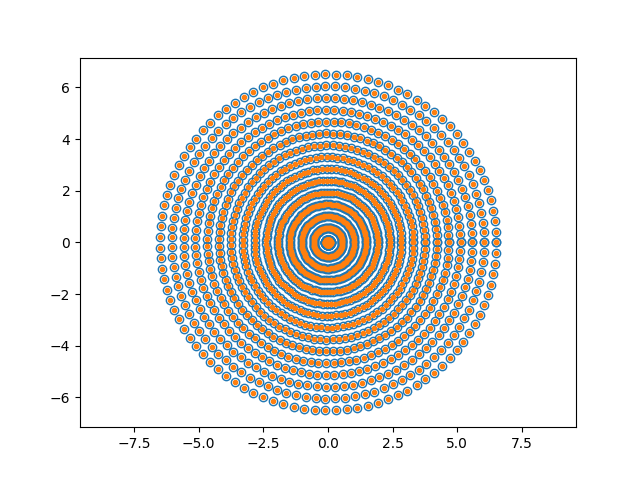

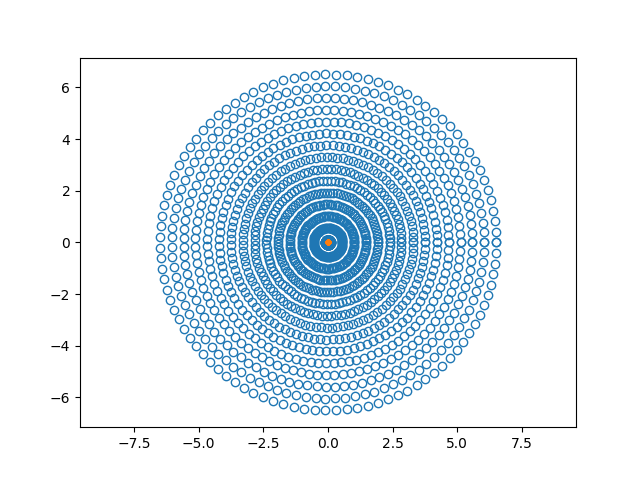

In [23]:

plt.figure()
# plt.plot(x_in_sigmas, px_in_sigmas,'.')

plt.plot(generator.x_sig,generator.px_sig,'o',mfc = 'none')
plt.plot(coord.df_sig.x_sig,coord.df_sig.px_sig,'.')
plt.axis('equal')

plt.figure()
plt.plot(generator.x_sig,generator.px_sig,'o',mfc = 'none')
plt.plot(coord.df_sig.y_sig,coord.df_sig.py_sig,'.')
plt.axis('equal')